# Lightweight Fine-Tuning Project

In [1]:
!pip install transformers
!pip install peft
!pip install datasets
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Loading and Evaluating a Foundation Model


In [53]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from transformers import DataCollatorWithPadding
from peft import LoraConfig, PeftModelForSequenceClassification, TaskType, AutoPeftModelForSequenceClassification
import torch
import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, PeftModelForSequenceClassification, TaskType, AutoPeftModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt

In [72]:
from datasets import load_dataset

# Load the IMDb movie reviews dataset
dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [73]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [76]:
df_raw = dataset["train"].to_pandas()


In [77]:
# prompt: just keep a sample of 10% of this data
df_train_raw = df_raw.sample(frac=0.1, random_state=42)
#df_test_raw = df_test_raw.sample(frac=0.008, random_state=42)


In [78]:
print("Training Dataset Preview:")
print(df_train_raw.head())
print("\nTest Dataset Preview:")
print(df_test_raw.head())

Training Dataset Preview:
                                                    text  label
6868   Dumb is as dumb does, in this thoroughly unint...      0
24016  I dug out from my garage some old musicals and...      1
9668   After watching this movie I was honestly disap...      0
13640  This movie was nominated for best picture but ...      1
14018  Just like Al Gore shook us up with his painful...      1

Test Dataset Preview:
                                                    text  label
6868   I could not believe how terrible and boring th...      0
24016  I rented Boogie Nights last week and I could t...      1
9668   First off, this movie is not near complete, my...      0
13640  I watched this mini in the early eighties. Sam...      1
14018  This movie was never intended as a big-budget ...      1


In [79]:
# Count the number of unique labels in the target column
if 'label' in df_train_raw.columns:
    print("\nUnique Labels in Training Dataset:")
    print(df_train_raw['label'].value_counts())
    print("\nUnique Labels in Test Dataset:")
    print(df_train_raw['label'].value_counts())


Unique Labels in Training Dataset:
label
0    1298
1    1202
Name: count, dtype: int64

Unique Labels in Test Dataset:
label
0    1298
1    1202
Name: count, dtype: int64


In [80]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_train_raw, test_size=0.1, stratify=df_train_raw['label'])

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 requires a pad token

# Tokenize and convert function
def tokenize_and_encode(examples):
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)
    tokenized_inputs['labels'] = examples['label']
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
val_dataset = val_dataset.map(tokenize_and_encode, batched=True)

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [59]:
# PEFT model configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1
)

# Load the pre-trained GPT-2 model
num_labels = df_train_raw['label'].nunique()
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=num_labels)
model.config.pad_token_id = model.config.eos_token_id
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

peft_model = PeftModelForSequenceClassification(model, peft_config)

# Print
peft_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 150,528 || all params: 124,590,336 || trainable%: 0.1208183594592762


## Performing Parameter-Efficient Fine-Tuning



In [60]:
# Compute metrics function
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {"accuracy": accuracy_score(p.label_ids, preds), "f1": f1, "precision": precision, "recall": recall}

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results/peft_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs/peft_model',
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,
    warmup_ratio=0.1,
)

# Initialize the Trainer with compute_metrics
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.682300,0.650390,0.608000,0.589545,0.620075,0.608000
2,0.649100,0.618791,0.668000,0.661842,0.674438,0.668000
3,0.621700,0.603789,0.700000,0.695716,0.705942,0.700000


TrainOutput(global_step=1689, training_loss=0.6646583064764191, metrics={'train_runtime': 617.172, 'train_samples_per_second': 10.937, 'train_steps_per_second': 2.737, 'total_flos': 1766842564608000.0, 'train_loss': 0.6646583064764191, 'epoch': 3.0})

In [61]:
# Evaluate
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

Evaluation Results: {'eval_loss': 0.6037885546684265, 'eval_accuracy': 0.7, 'eval_f1': 0.6957160342717259, 'eval_precision': 0.7059422750424449, 'eval_recall': 0.7, 'eval_runtime': 9.3194, 'eval_samples_per_second': 26.826, 'eval_steps_per_second': 3.434, 'epoch': 3.0}


In [62]:
peft_model.save_pretrained('model/peft_model')

## Performing Inference and comparison with a PEFT Model



In [63]:
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(
    "model/peft_model",
    num_labels=df_train_raw['label'].nunique()
)
inference_model.config.pad_token_id = inference_model.config.eos_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
trainer = Trainer(
    model=inference_model,
    args=training_args,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

Evaluation Results: {'eval_loss': 0.6037885546684265, 'eval_accuracy': 0.7, 'eval_f1': 0.6957160342717259, 'eval_precision': 0.7059422750424449, 'eval_recall': 0.7, 'eval_runtime': 9.3109, 'eval_samples_per_second': 26.85, 'eval_steps_per_second': 3.437}


In [65]:
def predict(text: str) -> str:
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

    return 'Positive' if predictions.item() == 1 else 'Negative'

In [66]:
# Compute metrics function
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {"accuracy": accuracy_score(p.label_ids, preds), "f1": f1, "precision": precision, "recall": recall}

In [67]:
# Examples to verify results
sentence = "This movie was fantastic! I loved it."
print(predict(sentence))

Negative


In [68]:
# Examples to verify results
sentence = "I hated it."
print(predict(sentence))

Negative


In [69]:
fine_tuned_results = {
    'eval_accuracy': evaluation_results['eval_accuracy'],
    'eval_f1': evaluation_results['eval_f1'],
    'eval_precision': evaluation_results['eval_precision'],
    'eval_recall': evaluation_results['eval_recall'],
}

In [70]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
original_model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=num_labels)

# Ensure tokenizer and model use the same pad token
original_model.config.pad_token_id = tokenizer.eos_token_id



# Initialize the Trainer
trainer = Trainer(
    model=original_model,
    args=training_args,  # Ensure you have defined training_args as before
    compute_metrics=compute_metrics,
    eval_dataset=val_dataset,  # Use the same validation dataset as for PEFT model
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate the model
original_results = trainer.evaluate()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


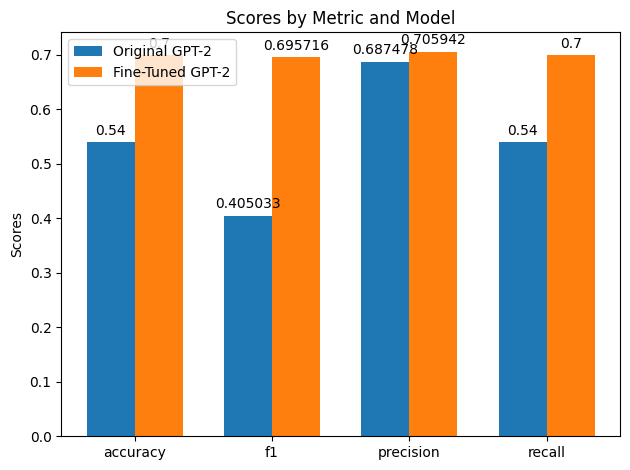

In [71]:
metrics = ['accuracy', 'f1', 'precision', 'recall']
original_scores = [original_results['eval_' + metric] for metric in metrics]
fine_tuned_scores = [fine_tuned_results['eval_' + metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_scores, width, label='Original GPT-2')
rects2 = ax.bar(x + width/2, fine_tuned_scores, width, label='Fine-Tuned GPT-2')

ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()